In [1]:
import os
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

ROOT = "./data"

train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)


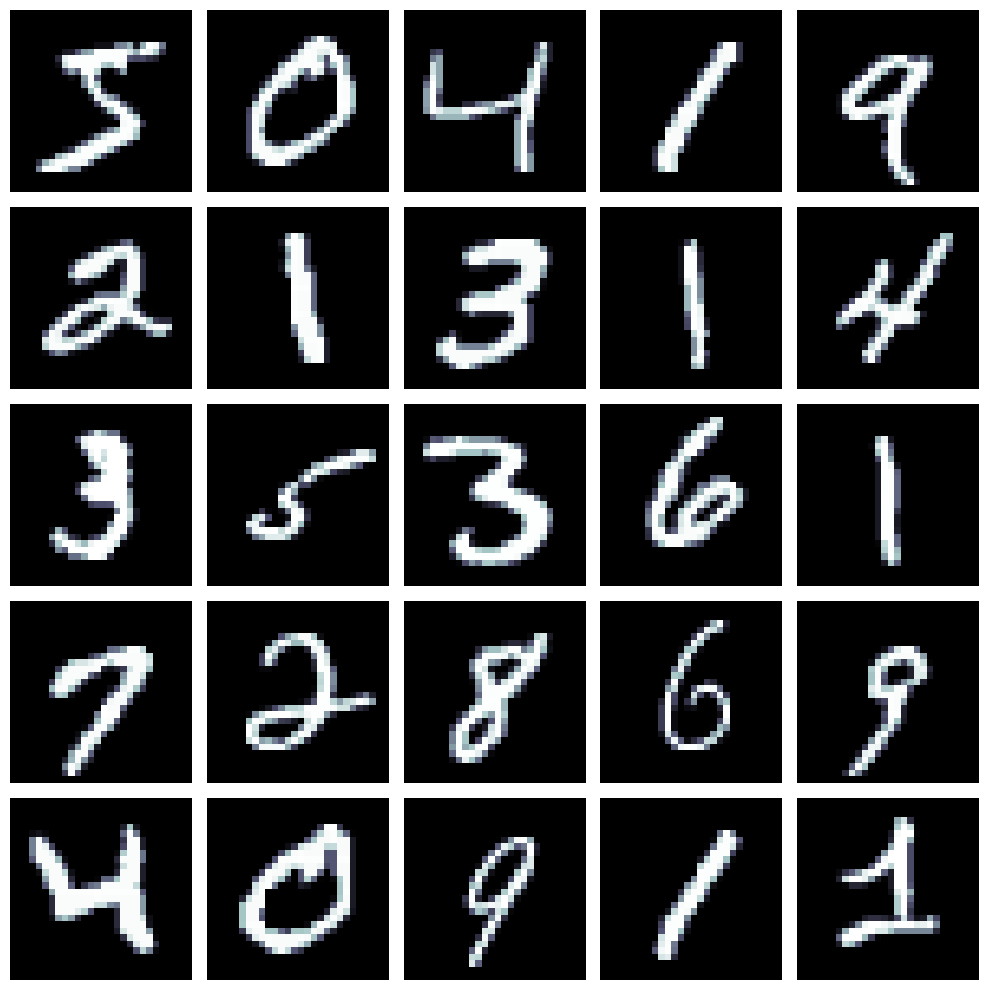

In [ ]:
def plot_images(images, n_images=25):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[i], cmap="bone")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)


In [3]:
# Split train into train and validation (90:10)
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data, [n_train_examples, n_valid_examples]
)
print(f"Train: {len(train_data)}, Valid: {len(valid_data)}")

Train: 54000, Valid: 6000


In [ ]:
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[mean], std=[std])]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[mean], std=[std])]
)

train_data.dataset.transform = train_transforms
test_data.transform = test_transform
valid_data.dataset.transform = test_transform

### Create DataLoaders

In [ ]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

print(
    f"Number of batches - Train: {len(train_dataloader)}, Valid: {len(valid_dataloader)}, Test: {len(test_dataloader)}"
)


Number of batches - Train: 211, Valid: 24, Test: 40


### Define LeNet Model

In [6]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes, in_channels=1, img_size=28):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=6, kernel_size=5, padding="same"
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        if img_size == 28:
            fc_input = 16 * 5 * 5
        else:
            fc_input = 16 * 35 * 35

        self.fc_1 = nn.Linear(fc_input, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [7]:
def train(model, optimizer, criterion, train_dataloader, device, epoch = 0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())


        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            print(f"| epoch {epoch:3d} | {idx:5d}/{len(train_dataloader):5d} batches | accuracy {total_acc / total_count:8.3f}")
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count if total_count > 0 else 0
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss 


### Train MNIST model

In [8]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [9]:
# Model setup
num_classes = len(train_data.dataset.classes)
lenet_model = LeNetClassifier(num_classes, in_channels=1, img_size=28).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

# Training loop
num_epochs = 10
save_model = './model'
os.makedirs(save_model, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(), os.path.join(save_model, 'lenet_mnist_model.pt'))

    # Print results
    print("-" * 80)
    print(f"| End of epoch {epoch:3d} | Time: {time.time() - epoch_start_time:5.2f}s | "
          f"Train Acc: {train_acc:8.3f} | Train Loss: {train_loss:8.3f} | "
          f"Valid Acc: {eval_acc:8.3f} | Valid Loss: {eval_loss:8.3f} |")
    print("-" * 80)

# Load best model
lenet_model.load_state_dict(torch.load(os.path.join(save_model, 'lenet_mnist_model.pt'), weights_only=True))
lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.688
| epoch   1 |   100/  211 batches | accuracy    0.898
| epoch   1 |   150/  211 batches | accuracy    0.932
| epoch   1 |   200/  211 batches | accuracy    0.945
--------------------------------------------------------------------------------
| End of epoch   1 | Time:  4.48s | Train Acc:    0.954 | Train Loss:    0.467 | Valid Acc:    0.960 | Valid Loss:    0.141 |
--------------------------------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.958
| epoch   2 |   100/  211 batches | accuracy    0.962
| epoch   2 |   150/  211 batches | accuracy    0.966
| epoch   2 |   200/  211 batches | accuracy    0.966
--------------------------------------------------------------------------------
| End of epoch   2 | Time:  2.91s | Train Acc:    0.967 | Train Loss:    0.121 | Valid Acc:    0.973 | Valid Loss:    0.095 |
-------------------------------------------------------------------------

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
print(f"MNIST Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


MNIST Test Accuracy: 0.9825, Test Loss: 0.0474


### Visualize Learned Filters

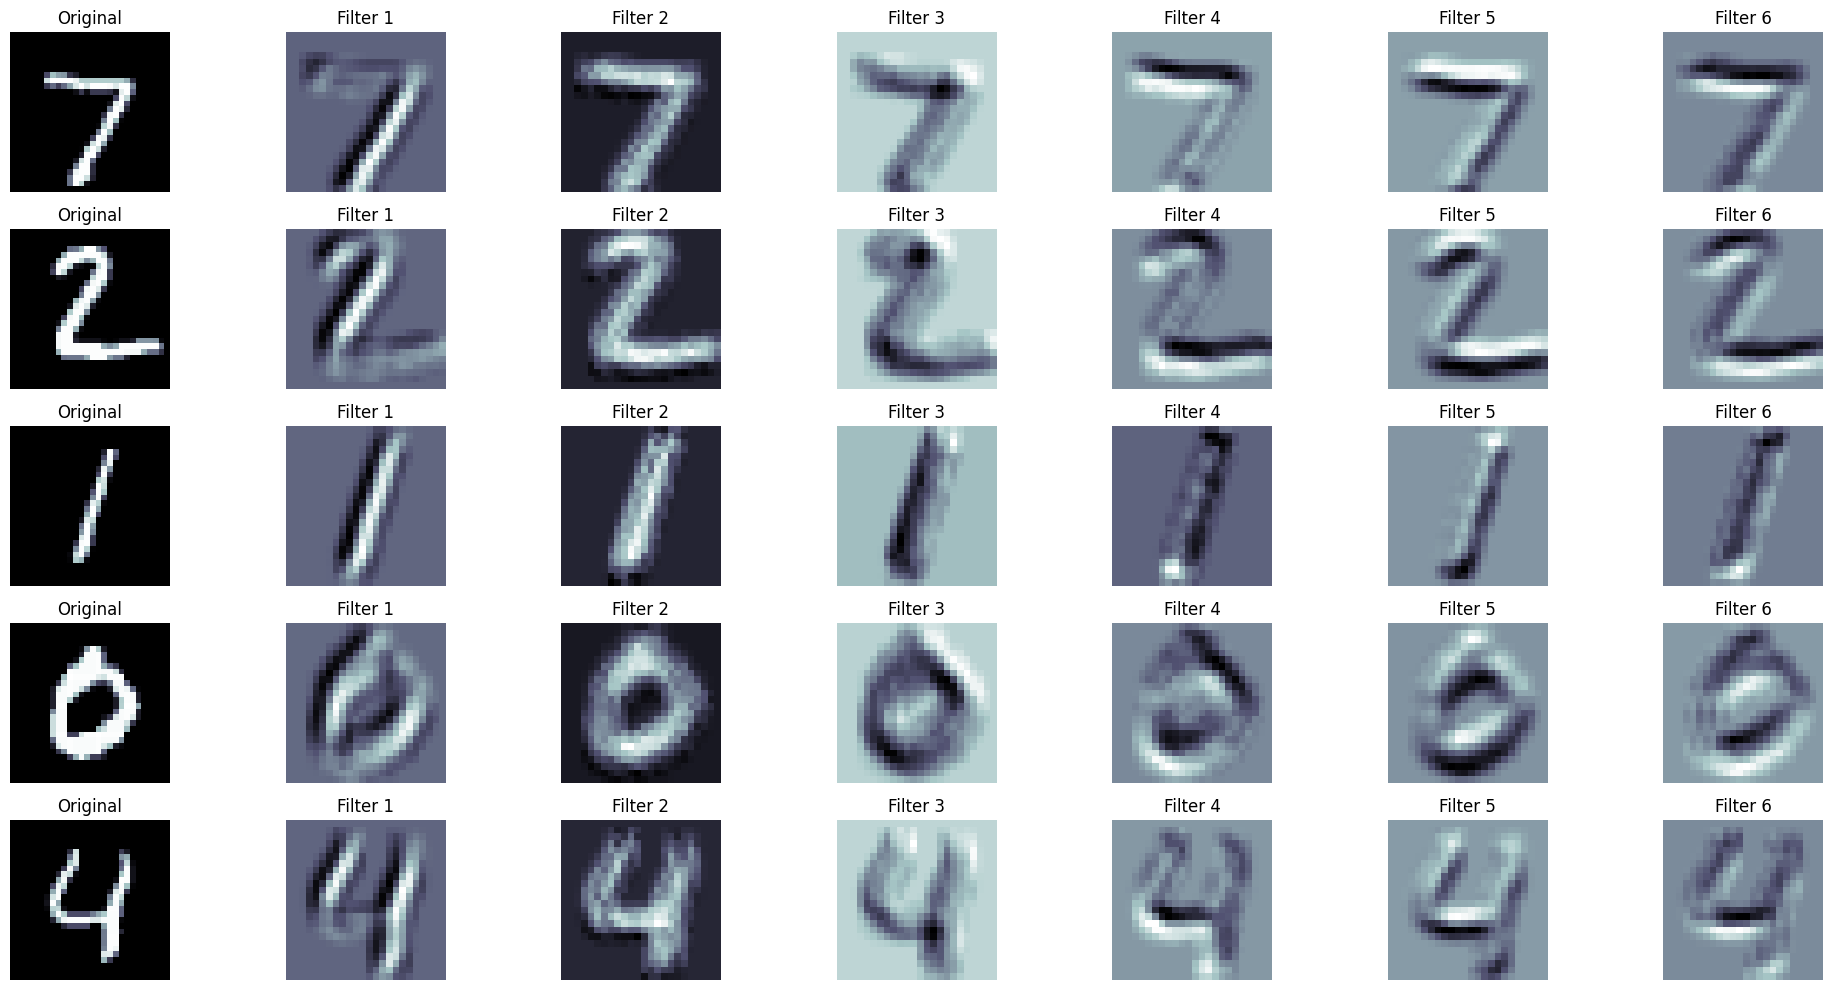

In [11]:
def plot_filtered_images(images, filters, n_images=5):
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_filters = filters.shape[0]
    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):
        ax = fig.add_subplot(n_images, n_filters + 1, i + 1 + (i * n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters + 1, i + 1 + (i * n_filters) + j + 1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j + 1}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

N_IMAGES = 5
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = lenet_model.conv1.weight.data
plot_filtered_images(images, filters)

MNIST Inference Examples:


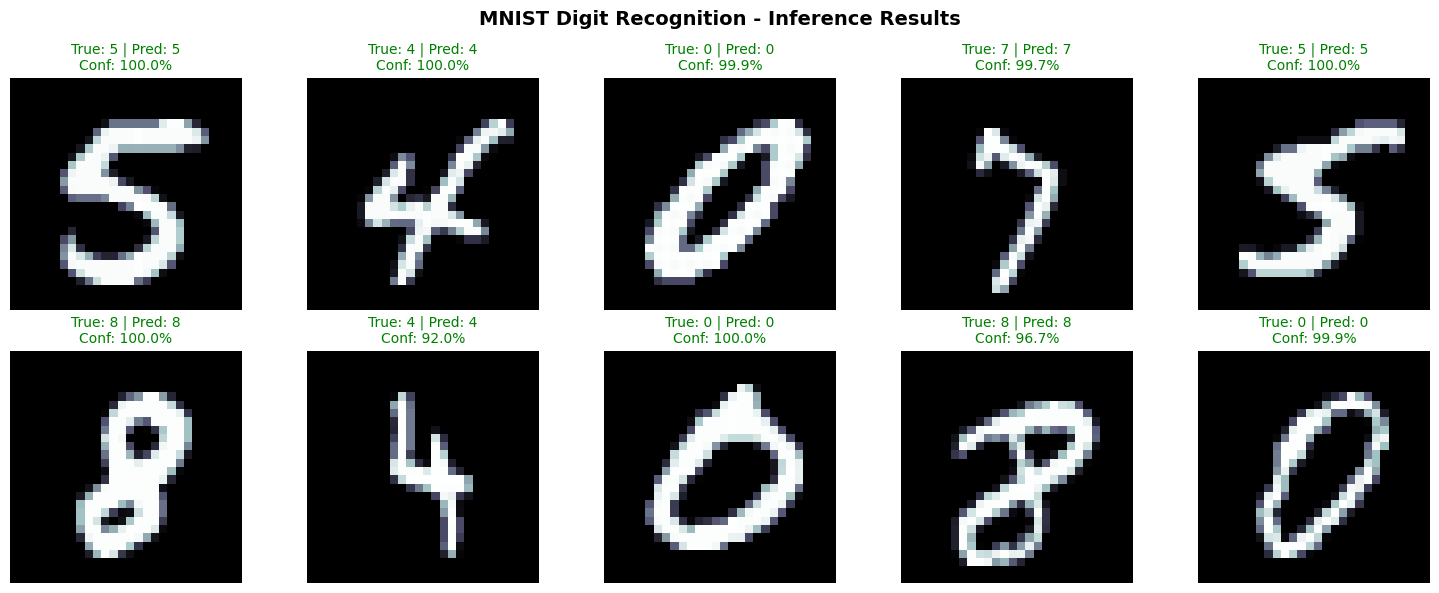

Inference completed for 10 random samples!
Green = Correct prediction, Red = Wrong prediction


In [12]:
def inference_mnist(image_tensor, model, device):
    """Predict digit from MNIST image tensor"""
    # Ensure image is in correct shape
    if image_tensor.dim() == 2:
        image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    elif image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    image_tensor = image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    probs = nn.Softmax(dim=1)(predictions)
    confidence, predicted_class = torch.max(probs, 1)

    return predicted_class.item(), confidence.item() * 100

# Test inference on random test images
print("MNIST Inference Examples:")
print("=" * 70)

n_samples = 10
random_indices = random.sample(range(len(test_data)), n_samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, test_idx in enumerate(random_indices):
    image, true_label = test_data[test_idx]

    # Inference
    pred_class, confidence = inference_mnist(image, lenet_model, device)

    # Visualize
    axes[idx].imshow(image.squeeze().numpy(), cmap='bone')
    color = 'green' if pred_class == true_label else 'red'
    axes[idx].set_title(f'True: {true_label} | Pred: {pred_class}\nConf: {confidence:.1f}%',
                        color=color, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('MNIST Digit Recognition - Inference Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Inference completed for {n_samples} random samples!")
print(f"Green = Correct prediction, Red = Wrong prediction")
